# Práctica 6b: El lenguaje ensamblador del ISA Intel x86-64.

## Objetivos

Este boletín está dedicado al estudio de los aspectos básicos del lenguaje ensamblador de nativo de los PCs,
basado en el ISA Intel x86-64. Por un lado, se pretende hacer ver el papel que juega el compilador a la hora de generar código ensamblador, y cómo mediante los distintos niveles de optimización podemos conseguir código más eficiente. Por otro lado, se ilustrará el ISA x86-64 mediante la ejecución controlada de sencillos programas en ensamblador, con el objetivo de que el alumno observe de primera mano aspectos fundamentales acerca de la arquitectura del computador, tales como el uso de los registros del procesador, las forma en que se accede a los datos en memoria, etc.

<font size="4">  
    <span style="color: red;">No olvides configurar Git para usar tu nombre y apellido(s), y tu dirección de correo electrónico universitario antes de comenzar.
    </span>
</font>

Edita las primeras líneas de la siguiente celda con tu nombre y email y ejecútala para configurar tu entorno Git antes de empezar.

In [ ]:
# Establece tu identidad
git config --global user.name "Nombre Apellido1 [Apellido2]"
git config --global user.email "alumno@um.es"

# Establece el editor por defecto
# para los mensajes de commit
git config --global core.editor "gedit"

<br>
<font size="5">  
    <span style="color: red;"><b>IMPORTANTE:</b><br> Añade este fichero a tu repositorio-bitácora "fc-alumno" <b>ANTES</b> de comenzar a realizar los ejercicios.
    </span>
</font>  
<font size="4">  
    Sigue las instrucciones a continuación.
</font>

Recuerda que para poder registrar tu trabajo en tu bitácora personal de prácticas, debes evitar trabajar en una copia de este *notebook* que no esté bajo control de versiones en Git en tu repositorio. Por ello, **ANTES DE REALIZAR NINGÚN CAMBIO en este fichero asegúrate de COLOCARLO DENTRO DIRECTORIO DE TU REPOSITORIO-BITÁCORA `fc-alumno`** y añadirlo al repositorio:
1. Cierra esta pestaña del navegador sin guardar los cambios.
2. Muévelo desde donde lo hayas descargado del AV (p.ej. `$HOME/Descargas`) al directorio donde tengas tu repositorio (se recomienda `$HOME/fc-alumno`).
3. Añádelo al repositorio:
    * `git add practica6b-ensamblador-boletin.ipynb`
    * `git commit -m "Añadiendo el notebook del boletín de la práctica 6b (sin empezar)"`

## Aspectos fundamentales del ISA x86-64.

### Registros en x86-64

La arquitectura x86-64 posee registros de tamaño 64 bits, cada uno de los cuales puede ser accedido en su totalidad, o bien por los 32, 16 u 8 bits inferiores. La siguiente imagen sacada de [aquí](https://hackmd.io/@paolieri/x86_64) muestra los 8 registros de propósito general que se direccionan mediante su nombre (RAX, RBX, etc.), y que son extensión de los registros de 16 bit existentes en la arquitectura primitiva del Intel 8086 (año 1978). De esta forma, los procesadores de Intel que implementan el ISA x86 han mantenido la compatibilidad hacia atrás, de forma que cada evolución de este ISA es compatible con la anterior, lo cual permite que el software existente (compilado para una especificación del ISA más antigua) siga funcionando en procesadores que implementan evoluciones del ISA más recientes.

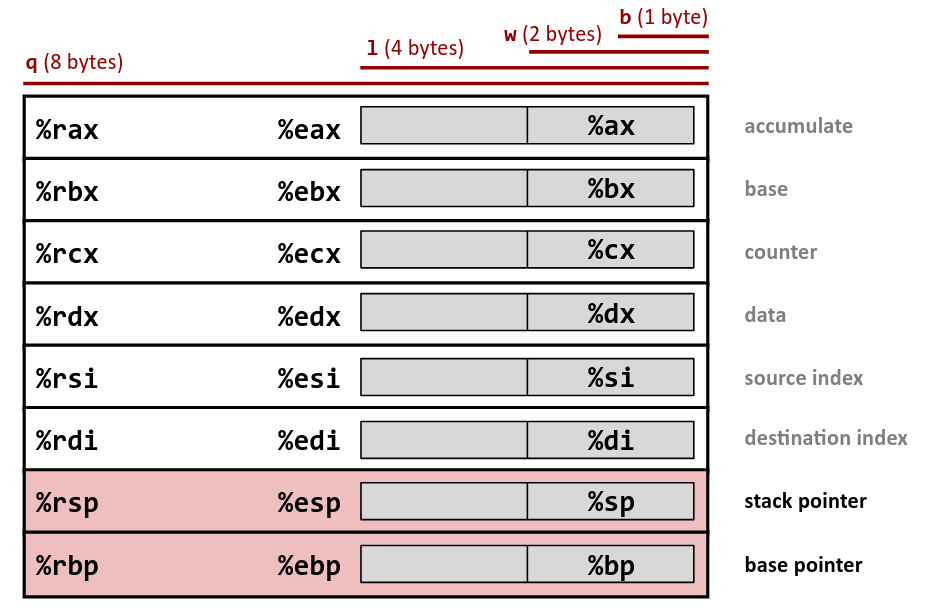

Así, por ejemplo, si nuestro programa en lenguaje C opera con una variable de tipo entero (cuya representación
interna utiliza 32 bits), la traducción correspondiente a ensamblador x86-64 utilizará instrucciones que operen únicamente con la mitad inferior de un registro de 64 bits, donde se almacena dicho dato. Por ejemplo, dicho entero podría guardarse en EAX, que son los 32 bits inferiores del registro RAX, como vemos a continuación.
```
|-----------------------------rax------------------------------|
|                               |--------------eax-------------|
|                                               |------ax------|
|                                                       |--al--|
0000000000000000000000000000000000000000000000000000000000000000
```

### Repertorio básico de instrucciones en x86-64.

Recuerda que en la sintaxis que utiliza por defecto el compilador `gcc`, el formato general de una instrucción
ensamblador x86-64 es: *mnemonic source, destination*. Por lo general, **el operando a la derecha de la
coma es el que se modifica como resultado de la ejecución de la instrucción**.

#### Instrucciones aritmético-lógicas

Sirven para hacer operaciones aritméticas (suma, resta, multiplicación, etc.) y/o lógicas (and, or, xor, desplazamiento de bits, etc.) con los operandos. Ejemplos:
```
add %rbx, %rax
# Suma RBX a RAX, y deja el resultado en RAX
```

También pueden operar con constantes (siempre precedidas por "$"):

```
sub $1234, %rax # Resta 1234 a RAX, y deja el resultado en RAX
```


####  Instrucciones de movimiento de datos

Sirven para copiar datos de un registro a otro, de la memoria a un
registro (y viceversa) y para cargar valores constantes en registros.

```
mov %rbx, %rax
# Copia el valor de RBX a RAX
mov $1234, %rax
# Establece RAX con el valor 1234
```
En particular, para leer y escribir datos en memoria es muy habitual establecer un registro con la dirección de
memoria a la que queremos acceder, y posteriormente utilizar dicho registro como “apuntador” para leer/escribir
de dicha dirección. Por ejemplo, si previamente hemos establecido RBX con la dirección de memoria de un
entero largo (64 bits), la siguiente instrucción lo leería de memoria y lo copiaría al registro RAX:
mov (%rbx), %rax # Usa RBX para leer un dato de memoria y copiarlo a RAX
A veces, queremos acceder a posiciones de memoria que están “cerca” de la dirección que tenemos guardada
en el registro “puntador”. 

Por ejemplo, la siguiente instrucción escribe el valor de RAX en memoria, en la dirección resultante de restar 8 al valor del registro RBP:
```
mov %rax, -8(%rbp) # Usa RBP para escribir en memoria el valor de RAX
```
Así, por ejemplo, si en ese momento el registro RBP tiene el valor 0x1028 y el registro RAX el valor 0x1234567890ABCDEF, la ejecución de esa instrucción escribiría el valor de 64 bits 0x1234567890ABCDEF a partir de la dirección de memoria 0x1020 (direcciones 0x1020 a la 0x1027).

#### Instrucciones de salto incondicional y condicional

Los saltos incondicionales rompen el flujo secuencial de ejecución del programa (una instrucción tras otra), ya que establecen el registro contador de programa (RIP en x86-64) a una dirección de código fija, indicada por una etiqueta (hacia atrás o adelante en el código). El programa sigue ejecutándose a partir de la instrucción destino del salto:

```
    jmp .L1
    [...]
L1: mov %rax, %rbx
```
Los saltos condicionales sólo saltan a la etiqueta si se cumple una determinada condición. Se
utilizan en la traducción de bucles (for, while, ...) y condiciones (if, switch, ...) de los lenguajes de alto nivel como C. La condición se comprueba en una instrucción `cmp` anterior.

```
    cmp $5, %rax      # Compara RAX con 5
    jge .L1           # Salta a .L1 si RAX mayor o igual que 5
    [...]
.L1: mov %rax, %rbx
```

#### Instrucciones de soporte de procedimientos

Las instrucciones `call` y `ret` sirven, respectivamente, para llamar y regresar de procedimientos. Al llamar a un procedimiento, se guarda la dirección de retorno (dirección de la siguiente instrucción tras el `call`), que es recuperada por la instrucción `ret`. Por ejemplo, para llamar a la función puts desde main y regresar posteriormente al `main` (en la instrucción `cmp`), se usarían estas instrucciones:
```
puts:   [...]
        ret       # Regresa al invocador (último call)

main:   [...]
        call puts # Salta a la etiqueta ’puts’
        [...]     # Regresa aquí mediante ’ret’
```

## Optimizaciones del compilador.

Utilizaremos de nuevo la aplicación web [Compiler Explorer](https://godbolt.org) para mostrar el lenguaje ensamblador de x86-64 generado por el compilador GCC con diferentes niveles de optimización. Partiremos del siguiente código en C.

```C
int myVar = 3;

int main() {
    // Suma 5 (3 + 5 = 8)
    myVar += 5;
    // Desplaza 2 bits a la izquierda (8 << 2 = 32)
    myVar = myVar << 2;
    // Multiplica por 2 (32*2 = 64)
    myVar = myVar * 2;
    // Resta 1 (64-1 = 63)
    --myVar;
    return myVar; // Resultado: 63 (ver con 'echo $?' en el shell)
}
```

- Una vez en el navegador en la página de *Compiler Explorer*, seleccionamos el lenguaje C en el panel izquierdo de código fuente (*source*)
- A continuación, copiamos y pegamos el código del programa anterior en C en dicho panel.
- En el panel derecho podemos elegir el compilador a utilizar, si bien por ahora utilizaremos el compilador por defecto (`gcc` compilando para el ISA `x86-64`).
- Al igual que en el boletín anterior, en el botón de *Output* del panel del compilador elegimos no usar la sintaxis de Intel. 
- En el botón *Add new* podemos añadir un nuevo panel del tipo *Clone compiler* para observar el resultado de compilar el programa con el mismo compilador, pero usando dos niveles distintos de optimización del código: para ello, pasamos las opciones -O0 (sin optimizar) y -O1, respectivamente.

El resultado de usar uno u otro nivel de optimización se muestra en la siguiente figura, donde podemos
comparar el código ensamblador de x86-64 generado mediante GCC para un mismo programa, sin y con optimización por parte del compilador.

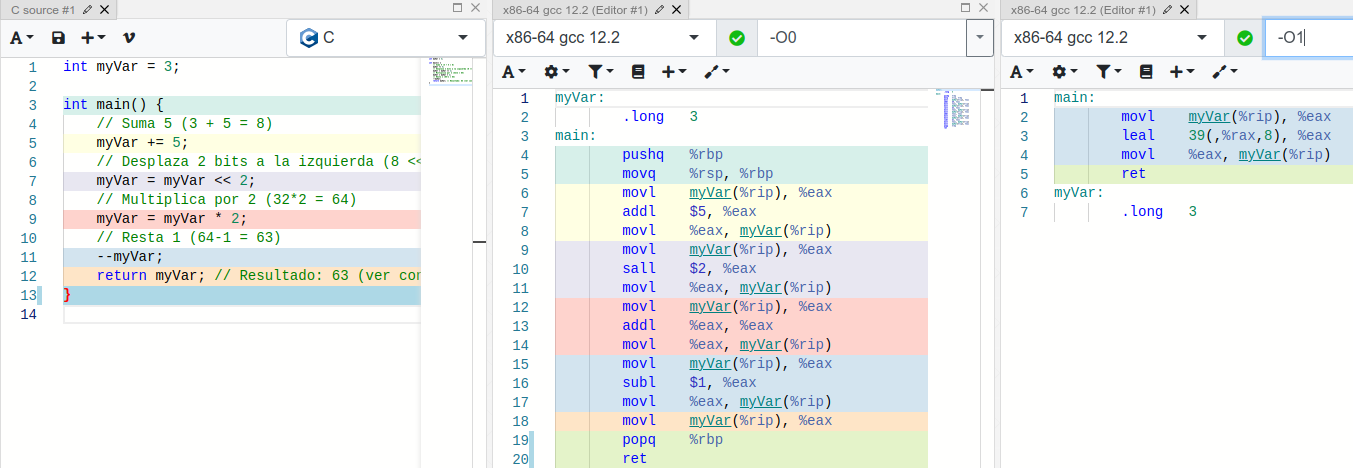

Vemos que el código ensamblador generado varía ostensiblemente en función del nivel de optimización que use el
compilador. Sin necesidad de entrar en los detalles, podemos observar a simple vista la gran diferencia en el número de instrucciones del ensamblador generado sin optimizaciones y con ellas (17 frente a 4 instrucciones), en gran parte porque el código sin optimizar lee de memoria la variable myVar en cuatro ocasiones y la escribe otras tantas (una por cada sentencia del código C: suma, desplazamiento, multiplicación y resta).

Como se puede apreciar fácilmente gracias al empleo de diferentes colores en la figura anterior, en el código sin optimizar cada sentencia C que opera sobre la variable se traduce en:
1) cargar el valor de la variable en memoria al registro EAX (32 bits menos significativos del registro EAX);
2) operación aritmético-lógica que lee el valor del registro EAX y escribe el resultado de nuevo en EAX; y 
3) guardar el valor del registro EAX en la memoria asignada a myVar.

Por su parte, al activar las optimizaciones no sólo se reduce a una lectura y una escritura de la variable en cuestión, sino que además el compilador traduce las cuatro sentencias en C con operaciones artiméticas a una única instrucción (línea 3 en la imagen anterior). Esta instrucción computa directamente el resultado que debe devolver el programa (`myVar*8+39`), ya que compilador es capaz determinar que el resultado del programa siempre será el mismo (63), pues ningún dato de entrada varía.

Independientemente del nivel de optimización, el código ensamblador generado automáticamente por un compilador es por lo general mas difícilmente comprensible que la traducción que pueda llevar a cabo un programador. Por esta razón, en adelante en este boletín vamos a hacer uso de traducciones manuales a ensamblador, en lugar de
apoyarnos el código generado automáticamente por el compilador.

In [ ]:
# Ejecuta esta celda para generar el fichero aritmetica.c
cat <<EOF > aritmetica.c
int myVar = 3;

int main() {
    // Suma 5 (3 + 5 = 8)
    myVar += 5;
    // Desplaza 2 bits a la izquierda (8 << 2 = 32)
    myVar = myVar << 2;
    // Multiplica por 2 (32*2 = 64)
    myVar = myVar * 2;
    // Resta 1 (64-1 = 63)
    --myVar;
    return myVar; // Resultado: 63 (ver con 'echo $?' en el shell)
}
EOF

In [ ]:
cat aritmetica.c

## Ejecución de programas en ensamblador x86-64 con GDB

Con el fin de mejorar la legibilidad e ilustrar más fácilmente el lenguaje ensamblador de x86-64, el código fuente del fichero `aritmetica.c` ha sido traducido de forma manual al código ensamblador que vemos a continuación. Ejecuta la siguiente celda para generar el fichero `aritmetica_manual.s`:

In [ ]:
# Ejecuta esta celda para generar el fichero aritmetica_manual.s
cat <<EOF > aritmetica_manual.s
        #### Segmento de datos (variables globales del programa)
        .data
myVar:  .long   3       # Variable de tipo entero (tamaño: 4 bytes) con valor inicial 3

        #### Segmento de código (instrucciones del programa)
        .text
        .globl  main

main:   # Procedimiento principal, llamado por el cargador del SO (loader)
        mov    myVar(%rip), %eax # Lee la variable myVar de memoria y
                                 # pone su valor en el registro EAX
        add    \$5, %eax          # Suma 5 a EAX
        sal    \$2, %eax          # Desplaza EAX 2 bits a la izquierda
        mov    \$2, %edx          # Carga la constante 2 en el registro EDX
        imul   %edx              # Multiplica EDX*EAX, producto en EDX:EAX
        dec    %eax              # Resta uno al valor de EAX
        mov    %eax, myVar(%rip) # Escribe el valor de EAX en memoria, 
                                 # en la dirección de la etiqueta myVar
        ret                      # Termina el procedimiento main y regresa al invocador
EOF

In [ ]:
cat aritmetica_manual.s

- En primer lugar, se observa la declaración de una primera parte del programa dedicada al segmento de datos (`.data`) en la que vemos la variable global `myVar` (referida simbólicamente por la etiqueta  `myVar:`), de tamaño 4 bytes (directiva `.long`) e inicializada con el valor 3.
- A continuación vienen las instrucciones del programa (segmento de código, `.text`). Distinguimos en primer lugar la función principal `main`, que comienza en la etiqueta `main:` y acaba con la instrucción `ret`. En el caso particular de este programa, todas las instrucciones que preceden a `ret` son de tipo aritmético-lógico (suma, multiplicación, desplazamiento de bits, etc.) y de movimiento de datos.

Podemos ensamblar y enlazar el código del fichero `aritmetica_manual.s` de la siguiente forma:

In [ ]:
gcc -g -static aritmetica_manual.s -o aritmetica_manual

Y ejecutarlo para comprobar su comportamiento; el programa no imprime por pantalla, pero podemos ver el valor que retorna `main` a través de la variable de entorno `$?`.

In [ ]:
./aritmetica_manual; echo $?

Una vez generado el ejecutable estático, procedemos a tracearlo con GDB fuera de Jupyter.

```bash
$ gdb aritmetica_manual
```

- Activamos la interfaz textual (TUI) con `layout split`
- A continuación escribiremos el comando `layout regs`, para mostrar los valores de los registros del procesador (panel superior) y el código ensamblador del programa (panel inferior).
- Establecemos un punto de ruptura con `break main`.
- Después, ejecutamos el programa (`run`) hasta que se detiene en la primera instrucción de `main`.
- Ahora, podemos ejecutar de instrucción en instrucción con el comando `stepi`. 

En la siguiente imagen vemos que tras ejecutar la primera instrucción, el registro RAX toma el valor leído de memoria que en ese momento tiene la variable `myVar` (inicialmente, 3). Los registros modificados por la última instrucción ejecutada aparecen resaltados en esta perspectiva: además del contador de programa (RIP), que pasa a apuntar a la siguiente instrucción, también se ha modificado RAX.

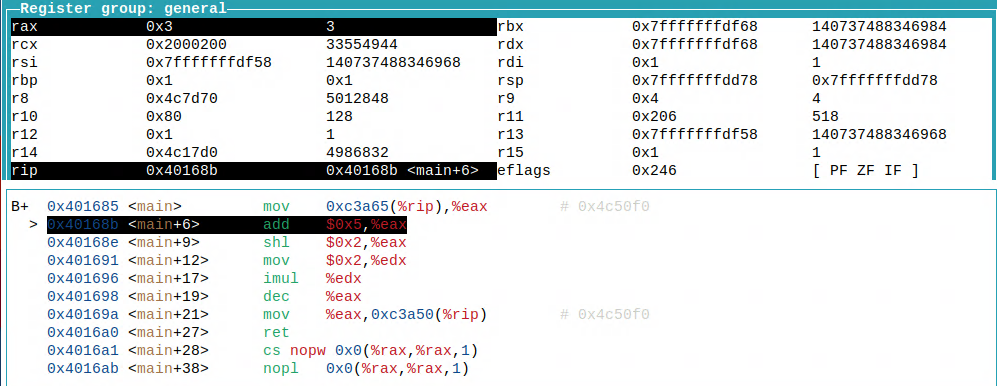

### Traducción de bucles y acceso a arrays en ensamblador.

Utilizaremos de nuevo la aplicación web *Compiler Explorer* para observar cómo el compilador lleva a cabo la
traducción a lenguaje ensamblador de x86-64 de cada una de las sentencias del programa en C `array.c`, cuyo código vemos en la siguiente imagen.

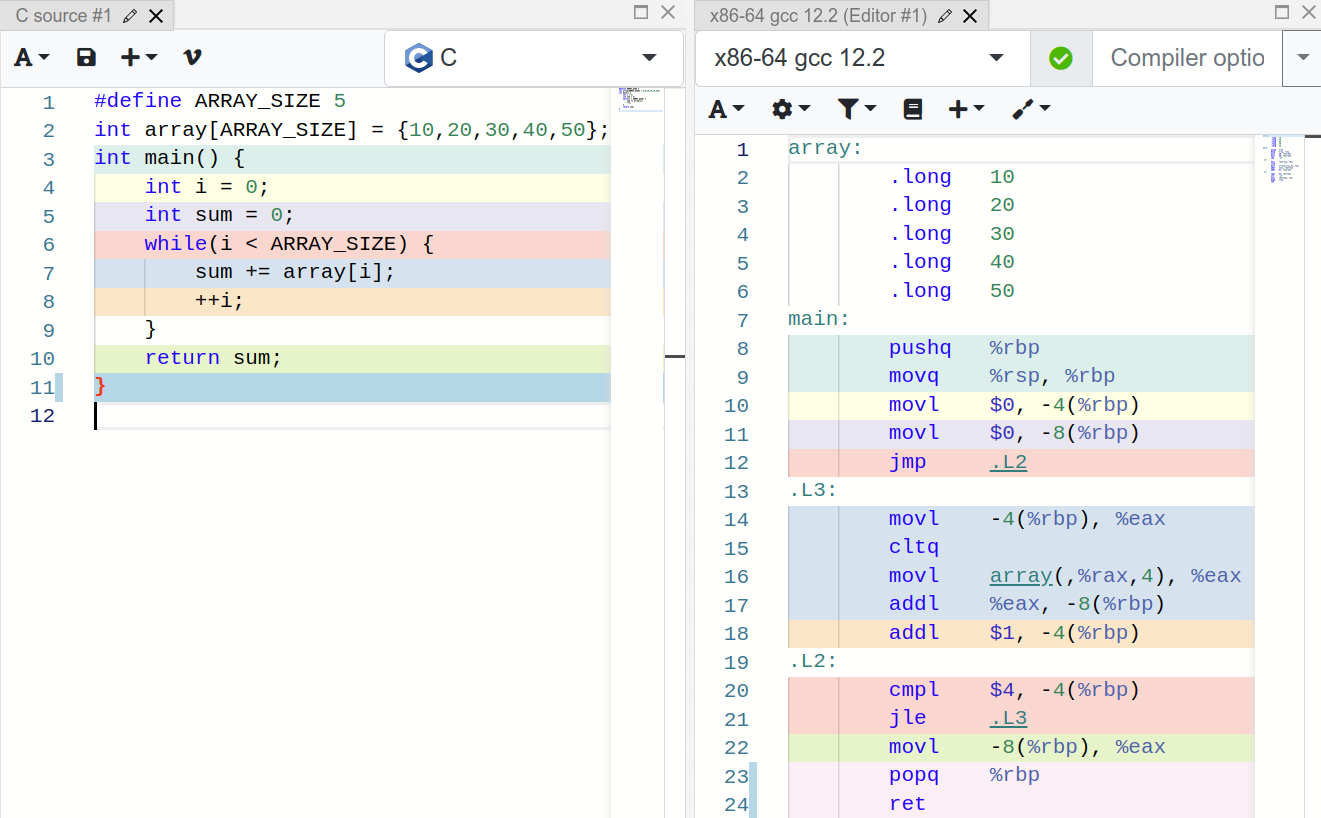

Se trata de un sencillo programa que recorre un array de enteros sumando sus valores.
- Vemos como la variable global `array` se traduce en las líneas 1 al 6, empezando por una etiqueta homónima que representa la dirección en memoria en la que se ubicará dicha variable (ya que, al ser global, es accesible en cualquier punto del programa).
- A continuación de la etiqueta, se observa la declaración de cada uno de los 5 elementos que conforman el array, inicializados con los valores `{10,20,30,40,50}`. Cada directiva `.long` indica al ensamblador que debe reservar 4 bytes (tamaño de un entero) con un determinado valor.
- Al contrario de lo que ocurre con las variables globales como `array`, las variables locales `i` y `sum` no tienen un espacio en memoria permanentemente asignado ya que una variable local sólo es accesible cuando la función en la que se declara está en ejecución. 

Las variables locales se almacenan en una zona de la memoria denominada pila, que se utiliza para el soporte de procedimientos (llamadas a funciones, variables locales, paso de parámetros, etc.). Durante la ejecución de una función, el valor del registro RBP suele fijarse a una dirección fija de la pila, lo cual permite acceder a las variables que están en la pila usando dicho registro como apuntador. 

- Las instrucciones en las líneas 10 y 11 de la imagen anterior se encargan, respectivamente, de escribir el valor 0 en las variables locales `i` y `sum`, y cuyas direcciones en memoria se obtienen restando 4 y 8 al valor del registro RBP.
- En la línea 12 tenemos un salto incondicional a la etiqueta `.L2`, lugar en el que se encuentran las instrucciones que comprueban la condición del bucle *while*: se compara el valor de la variable i con 4, y se salta a la etiqueta `.L3` (inicio del cuerpo del bucle) si en la comparación anterior i resultó ser menor o igual que 4 (`jle`, *jump if less or equal than*).

El cuerpo del bucle se traduce en dos partes: 
- La lectura del elemento i-ésimo del array (líneas 14-17) para sumarlo a la variable local `sum`, e incremento de la variable local `i`. La instrucción en la línea 16 realiza el acceso al elemento i-ésimo del array usando el registro EAX, en el cual se ha copiado previamente el valor de `i` leído de la pila (línea 14).
- La instrucción mov de la línea 16 lee de memoria en la dirección `array+rax*4` (cada entero son 4 bytes) y copia el valor a EAX, mientras que la línea 17 suma el valor de EAX a la variable sum ubicada en la pila.

In [ ]:
cat <<EOF > array.c
#define ARRAY_SIZE 5
int array[ARRAY_SIZE] = {10,20,30,40,50};
int main() {
    int i=0, sum = 0;
    while(i < ARRAY_SIZE) {
        sum += array[i];
        ++i;        
    }
    return sum;
}
EOF

El código fuente en C del fichero `array.c` ha sido traducido de forma manual al código ensamblador que podemos generar ejecutando la siguiente celda, para crear el fichero `array_manual.s`.

In [ ]:
# Ejecuta esta celda para generar el fichero array_manual.s
cat <<EOF > array_manual.s
        #### Segmento de datos (variables globales del programa)
        .data
array:  .long   10
        .long   20
        .long   30
        .long   40
        .long   50

        #### Segmento de código (instrucciones del programa)
        .text
        .globl  main

main:   # Procedimiento principal, llamado por el cargador del SO (loader)
        # Variables locales a main:
        # i -> registro ESI
        # sum -> registro EAX
        mov    \$0, %esi        # Inicializa i a 0
        mov    \$0, %eax        # Inicializa sum a 0
        lea    array(%rip), %rbx  # RBX: dirección de memoria de array

        ##### Bucle while:
inicio_while:
        # Comprobación de la condición
        cmp    \$5, %esi        # Compara ESI con 5 (tamaño del array)
        jge     fin_while      # Salta a fin_while si cmp anterior fue mayor o igual
        mov    (%rbx), %ecx    # Lee variable en la dirección de memoria
                               # array+4*i y lo guarda en el registro ECX
        add    %ecx, %eax      # sum += array[i]
        # Incremento de la variable de control
        inc     %esi            # i++
        add    \$4, %rbx         # EDX: dirección del siguiente elemento del array
        # Regresa al inicio del bucle
        jmp     inicio_while
fin_while:
        # EAX contiene sum (valor retornado por main)
        ret                     # Termina el procedimiento main,
                                # regresa al invocador
EOF

El contenido del fichero generado,numerado para mayor claridad, es el siguiente:

In [ ]:
nl array_manual.s

Esta traducción manual a ensamblador es diferente al código que vimos anterior en *Compiler Explorer*, por dos razones. Primero, utiliza dos registros para mantener las variables locales `sum` (EAX) e `i` (ESI), en vez de guardarlas en memoria (en la pila). En segundo lugar, mantiene en cada iteración del bucle la dirección del elemento i-ésimo del array en el registro RBX. 

En el segmento de código, tras la inicialización de los registros donde se guarda el valor de sum e i, tenemos la instrucción que coloca en RBX la dirección de memoria donde comienza el array. 

Después, tenemos el bucle while, entre las etiquetas `inicio_while` y `fin_while`), que se divide en:

1. Comprobación de la condición de continuación del bucle, mediante una instrucción de comparación (línea 21) seguida de un salto condicional `jge` a la etiqueta `fin_while`. El salto se producirá sólo cuando el registro que alberga la variable `i` (ESI) sea mayor o igual que 5 (o sea, cuando se deba salir del bucle)

2. Cuerpo del bucle: Lectura del elemento i-ésimo del vector `array` situado en memoria (en el segmento de datos), mediante la instrucción `mov (%rbx), %ecx` , que lee el entero (4 bytes) en la dirección de memoria dada por el valor actual del registro RBX, y lo guarda en el registro ECX. El elemento del array leído de memoria se suma a la variable local `sum` (línea 25)

3. Incremento de la variable `i` que dirige el bucle while, mediante la instrucción `inc %esi`.

4. Sumar 4 a la dirección de memoria contenida en RBX, para apuntar al siguiente elemento del array en memoria (puesto que cada elemento ocupa 4 bytes).

5. Vuelta al comienzo del bucle mediante la instrucción de salto incondicional `jmp inicio_while`, para comprobar nuevamente la condición con el nuevo valor de la variable `i`.

Podemos ensamblar y enlazar el código del fichero `array_manual.s` de la siguiente forma:

In [ ]:
gcc -g -static array_manual.s -o array_manual

Y ejecutarlo para comprobar su comportamiento; el programa no imprime por pantalla, pero podemos ver el valor que retorna `main` a través de la variable de entorno `$?`.

In [ ]:
./array_manual; echo $?

Una vez generado el ejecutable estático, procedemos a tracearlo con GDB fuera de Jupyter.

```bash
gdb array_manual
```

Una vez en GDB:
- Pasamos al modo de visor de registros de la CPU con `layout regs`.
- Ponemos un punto de ruptera en la línea 17 con  `break 17`.
- Lanzamos el programa con `run`.
- Ejecutamos instrucción a instrucción con `stepi`.
- Mostramos el valor del registro RBX al llegar a la línea 20.
- Mostramos el contenido de la memoria en la dirección apuntada por RBX (dirección donde se ubica `array`).
- Ejecutamos instrucción a instrucción con `stepi` y vemos cómo van cambiando los valores de los registros con cada instrucción, cómo se van leyendo de memoria a registros los valores del array para sumarlos, etc.

La siguiente imagen muestra el estado de los registros tras ejecutar la línea 19, y los valores en las direcciones de memoria donde se ubica `array` en ese punto:

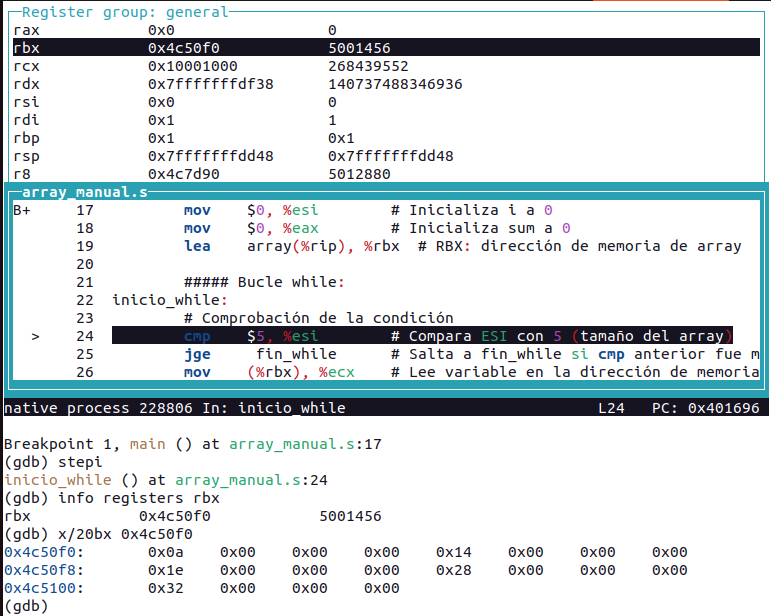